In [ ]:
%matplotlib inline
import mne
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
import matplotlib
matplotlib.use('qt5agg')

### Loading data

In [ ]:
from mne_bids import (write_raw_bids, BIDSPath, read_raw_bids, print_dir_tree)

bids_root = os.path.join('data', 'P3')
bids_path = BIDSPath(subject='001', session='P3', task='P3',
                     datatype='eeg', suffix='eeg', root=bids_root)

raw = read_raw_bids(bids_path=bids_path)
events, event_id = mne.events_from_annotations(raw)
# ccs_eeg_utils.read_annotations_core(bids_path,raw)

raw.load_data()

In [ ]:
sfreq = raw.info['sfreq']
data, times = raw[:5, int(sfreq * 1):int(sfreq * 460)]
_ = plt.plot(times, data.T)
_ = plt.title('Sample channels')

### Information

In [32]:
n_time_samps = raw.n_times
time_secs = raw.times
ch_names = raw.ch_names
n_chan = len(ch_names)  # note: there is no raw.n_channels attribute
print('the (cropped) sample data object has {} time samples and {} channels.'
      ''.format(n_time_samps, n_chan))
print('The last time sample is at {} seconds.'.format(time_secs[-1]))
print('The first few channel names are {}....'.format(', '.join(ch_names[:5])))
# Give the sample rate
print('sample rate:', raw.info['sfreq'], 'Hz')
# Give the size of the data matrix
print('%s channels x %s samples' % (len(raw), len(raw.times)))
print(ch_names)

the (cropped) sample data object has 140100 time samples and 33 channels.
The last time sample is at 466.99666666666667 seconds.
The first few channel names are FP1, F3, F7, FC3, C3....
sample rate: 300.0 Hz
140100 channels x 140100 samples
['FP1', 'F3', 'F7', 'FC3', 'C3', 'C5', 'P3', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Oz', 'Pz', 'CPz', 'FP2', 'Fz', 'F4', 'F8', 'FC4', 'FCz', 'Cz', 'C4', 'C6', 'P4', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'HEOG_left', 'HEOG_right', 'VEOG_lower']


### Since, P300 lets see Pz channel 

In [ ]:
eeg_channel_indices = mne.pick_channels(raw.ch_names, ['Pz'])

start_stop_seconds = np.array([11, 13])
start_sample, stop_sample = (start_stop_seconds * sfreq).astype(int)

eeg_data, times = raw[eeg_channel_indices, start_sample:stop_sample]
print(eeg_data)

import seaborn as sns
plt.plot(times, eeg_data.T)
# plt.plot(eeg_data[1], eeg_data[0].T)

### Display Montage settings

In [ ]:
import seaborn as sns
# sns.lineplot(data=eeg_data, x=0, y=1)
montage_dir = os.path.join(os.path.dirname(mne.__file__),
                           'channels', 'data', 'montages')

print('\nBUILT-IN MONTAGE FILES')
print('======================')
print(sorted(os.listdir(montage_dir)))
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

raw.set_montage(ten_twenty_montage, match_case=False)
print(ten_twenty_montage)

fig = plt.figure()
ax2d = fig.add_subplot(121)
ax3d = fig.add_subplot(122, projection='3d')
raw.plot_sensors(ch_type='eeg', axes=ax2d)
raw.plot_sensors(ch_type='eeg', axes=ax3d, kind='3d')
ax3d.view_init(azim=70, elev=15)

In [ ]:
fig = ten_twenty_montage.plot(kind='3d')
fig.gca().view_init(azim=70, elev=15)
ten_twenty_montage.plot(kind='topomap', show_names=True)

### Filtering

In [ ]:
raw.resample(300, npad="auto")
raw.filter(0.5, 50, fir_design='firwin')

## Removing muscle artifact

In [ ]:
# The threshold is data dependent, check the optimal threshold by plotting
# ``scores_muscle``.
threshold_muscle = 25  # z-score
# Choose one channel type, if there are axial gradiometers and magnetometers,
# select magnetometers as they are more sensitive to muscle activity.
annot_muscle, scores_muscle = mne.preprocessing.annotate_muscle_zscore(
    raw, ch_type="eeg", threshold=threshold_muscle, min_length_good=0.2,
    filter_freq=[110, 140])

In [ ]:
fig, ax = plt.subplots()
ax.plot(raw.times, scores_muscle)
ax.axhline(y=threshold_muscle, color='r')
ax.set(xlabel='time, (s)', ylabel='zscore', title='Muscle activity')

In [ ]:
order = np.arange(144, 164)
nraw = raw.copy()
nraw.set_annotations(annot_muscle)
nraw.plot(start=5, duration=20)

In [33]:
eog_events = mne.preprocessing.find_eog_events(raw)
onsets = eog_events[:, 0] / raw.info['sfreq'] - 0.25
durations = [0.5] * len(eog_events)
descriptions = ['bad blink'] * len(eog_events)
blink_annot = mne.Annotations(onsets, durations, descriptions,
                              orig_time=raw.info['meas_date'])
raw.set_annotations(blink_annot)

Using EOG channels: HEOG_left, HEOG_right, VEOG_lower
EOG channel index for this subject is: [30 31 32]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 3000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 13 significant peaks
Number of EOG events detected: 13


<RawEEGLAB | sub-001_ses-P3_task-P3_eeg.fdt, 33 x 140100 (467.0 s), ~35.3 MB, data loaded>

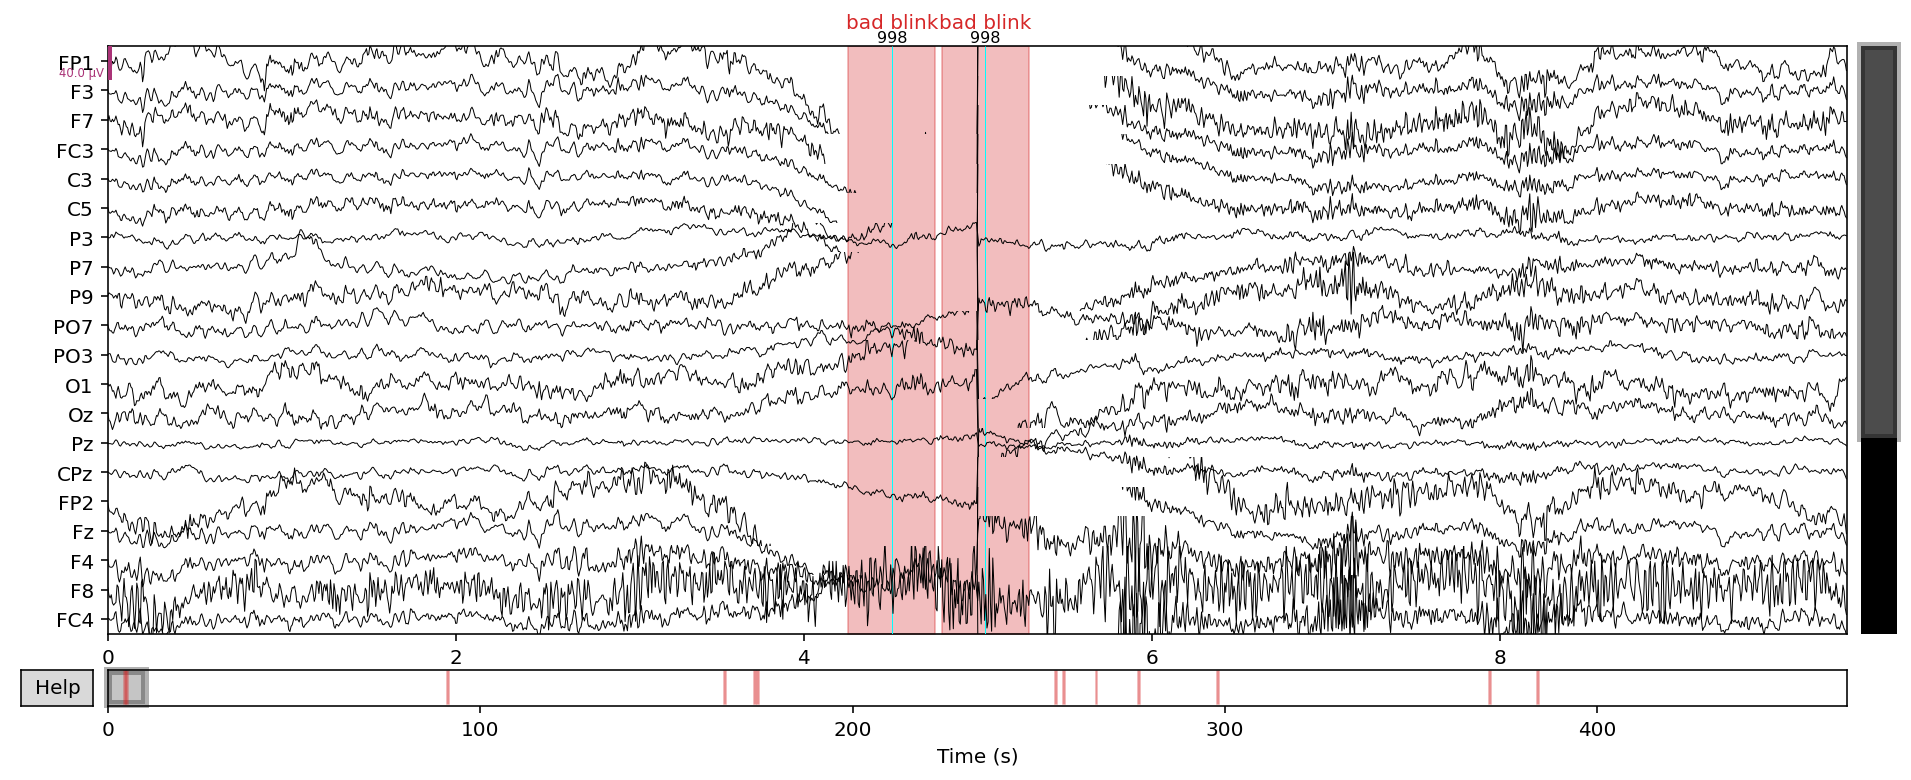

In [34]:
eeg_picks = mne.pick_types(raw.info, meg=False, eeg=True)
raw.plot(events=eog_events, order=eeg_picks)

Not setting metadata
Not setting metadata
402 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 402 events and 211 original time points ...
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7', 'F8']
    Rejecting  epoch based on EEG : ['F4', 'F8']
    Rejecting  epoch based on EEG : ['FP1', 'F3', 'F7', 'FP2', 'Fz', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['FP1', 'F7', 'FP2']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['FP2', 'F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['FP1', 'F7', 'FP2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting

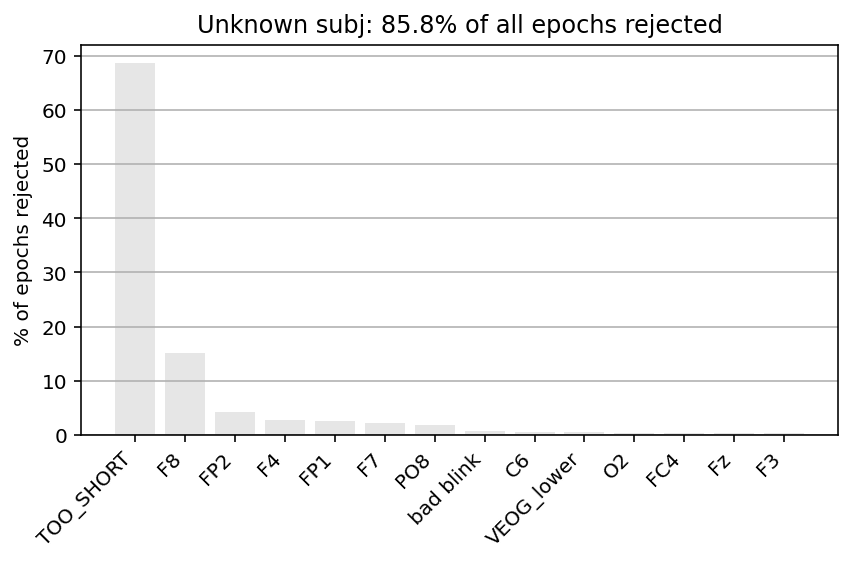

In [51]:
reject_criteria = dict(eeg=100e-6,       # 100 µV
                       eog=200e-6)       # 200 µV

flat_criteria = dict(eeg=1e-6)           # 1 µV
epochs = mne.Epochs(raw, events, tmin=-0.2, tmax=0.5, reject_tmax=0,
                    reject=reject_criteria, flat=flat_criteria, preload=True)
epochs.plot_drop_log()

### ICA

In [ ]:
ica = mne.preprocessing.ICA(method="fastica")
ica.fit(raw,decim=3, verbose=True)
eog_indices, eog_scores = ica.find_bads_eog(raw)
ica.exclude = eog_indices

# barplot of ICA component "EOG match" scores
ica.plot_scores(eog_scores, exclude=eog_indices)

In [ ]:
ica.plot_sources(raw, show_scrollbars=False)

In [ ]:
mne.viz.plot_events(events, event_id=event_id, sfreq=raw.info['sfreq']);

In [ ]:
eog_evoked = mne.preprocessing.create_eog_epochs(raw).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint()
# plot ICs applied to the averaged EOG epochs, with EOG matches highlighted
ica.plot_sources(eog_evoked)

In [ ]:
ica.exclude = []
# find which ICs match the EOG pattern
eog_indices, eog_scores = ica.find_bads_eog(raw)
ica.exclude = eog_indices

# barplot of ICA component "EOG match" scores
ica.plot_scores(eog_scores)

# plot diagnostics
# ica.plot_properties(raw, picks=eog_indices)

# plot ICs applied to raw data, with EOG matches highlighted
ica.plot_sources(raw, show_scrollbars=True)


# ica.plot_overlay(raw, exclude=eog_indices, picks='eeg')

In [ ]:
eog_epochs = mne.preprocessing.create_eog_epochs(raw)  # get single EOG trials
eog_inds, scores = ica.find_bads_eog(eog_epochs)  # find via correlation

ica.plot_scores(scores, exclude=eog_inds);  # look at r scores of components

In [ ]:
from time import time
def run_ica(method, fit_params=None):
    ica = mne.preprocessing.ICA(n_components=20, method=method, fit_params=fit_params,
              max_iter='auto', random_state=35)
    t0 = time()
    ica.fit(nraw)
    fit_time = time() - t0
    title = ('ICA decomposition using %s (took %.1fs)' % (method, fit_time))
    ica.plot_components(title=title)

In [ ]:
run_ica('fastica')

In [ ]:
run_ica('picard')

In [ ]:
run_ica('infomax')

In [ ]:
raw.plot_psd(average=True)

### EPOCHING

In [ ]:
epochs = mne.Epochs(raw, events, event_id, tmin=-0.1, tmax=1,
                    baseline=(None, 0), preload=True)
print(epochs)

In [ ]:
print(epochs.events[:3])
print(epochs.event_id)

In [ ]:
print(epochs[1:5])
print(epochs['stimulus/11'])
print(epochs['stimulus/21'])
print(epochs['stimulus/31'])
print(epochs['response'])

In [ ]:
epochs.plot_drop_log();

In [ ]:
# epochs.plot(block=True, events=events);

In [ ]:
epochs.plot_image(12, cmap='interactive', sigma=1., vmin=-400, vmax=400);

In [ ]:
stim_events = dict((k, event_id[k]) for k in event_id.keys() if "stimulus" in k)
epochs = mne.Epochs(raw, events, stim_events, tmin=-0.2, tmax=0.8, picks=['Pz'])


# Average epochs for faces and car
rare_stim = set(range(11, 55+1, 11))
freq_stim = set(range(11, 55+1)) - set(range(11, 55+1, 11))

evoked_a = epochs[["stimulus/{}".format(f) for f in rare_stim]].average()
evoked_b = epochs[["stimulus/{}".format(f) for f in freq_stim]].average()

# Plot evokeds
mne.viz.plot_compare_evokeds({"Target A": evoked_a, "Target B": evoked_b}, show=False, title="ERPs before ICA", combine="mean")

In [ ]:
rare_stim